gradcam.shape=(50, 242)


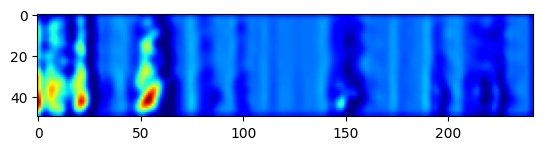

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

grad_npy_file = '../GradCam/proximity/Classroom/80MHz/3mo/m1/Slots/Test_m1/A_batch/batch_0.npy'
gradcam = np.load(grad_npy_file)
print(f'{gradcam.shape=}')
plt.imshow(gradcam, cmap='jet');

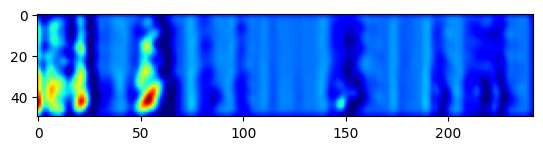

In [65]:
png_file = '../GradCam/proximity/Classroom/80MHz/3mo/m1/Slots/Test_m1/A_batch/batch_0.png'
img = plt.imread(png_file)
plt.imshow(img)

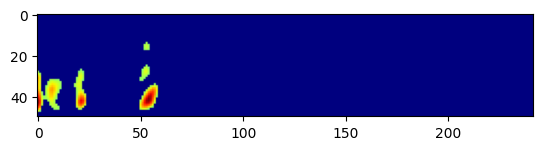

In [66]:
def simplify_gradcam(gradcam):
    # Apply a threshold to the gradcam
    threshold = 0.5
    gradcam[gradcam < threshold] = 0

    # Normalize the gradcam
    gradcam = (gradcam - np.min(gradcam)) / (np.max(gradcam) - np.min(gradcam))

    # Multiply with the original image
    simplified_gradcam = gradcam

    return simplified_gradcam
simplified_gradcam = simplify_gradcam(gradcam)
plt.imshow(simplified_gradcam, cmap='jet');


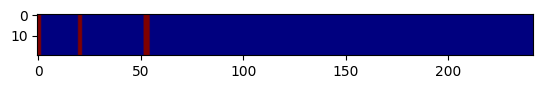

In [71]:
def simplify_gradcam2(gradcam):
  gradcam_line = gradcam.sum(axis=0)/50
  gradcam_line = gradcam_line.reshape(1, 242)
  gradcam_all = np.repeat(gradcam_line, 20, axis=0)
  gradcam_all = np.where(gradcam_all >= 0.20, 1, 0)
  return gradcam_all

simplified_gradcam2 = simplify_gradcam2(gradcam)
plt.imshow(simplified_gradcam2, cmap='jet');

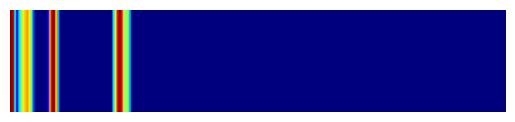

In [89]:
def simplify_gradcam3(gradcam):
  gradcam = np.where(gradcam >= 0.40, 1, 0)
  gradcam_line = gradcam.sum(axis=0)/50
  gradcam_line = gradcam_line.reshape(1, 242)
  gradcam_all = np.repeat(gradcam_line, 50, axis=0)
  # gradcam_all = np.where(gradcam_all >= 0.20, 1, 0)
  return gradcam_all

simplified_gradcam3 = simplify_gradcam3(gradcam)
plt.imshow(simplified_gradcam3, cmap='jet');
plt.axis('off');

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
test_csv = '../GradCam/proximity/Classroom/80MHz/3mo/m1/Slots/Test_m1/test_set.csv'
df = pd.read_csv(test_csv)
df

,filename,label,predicted_label,predicted_prob,right
0,O_batch/batch_605.mat,O,O,0.836124,True
1,O_batch/batch_278.mat,O,O,0.999962,True
2,O_batch/batch_533.mat,O,O,0.999976,True
3,O_batch/batch_651.mat,O,O,0.995002,True
4,O_batch/batch_350.mat,O,O,0.999981,True
...,...,...,...,...,...
19744,G_batch/batch_632.mat,G,G,1.000000,True
19745,G_batch/batch_1133.mat,G,G,1.000000,True
19746,G_batch/batch_1114.mat,G,G,1.000000,True
19747,G_batch/batch_814.mat,G,G,1.000000,True


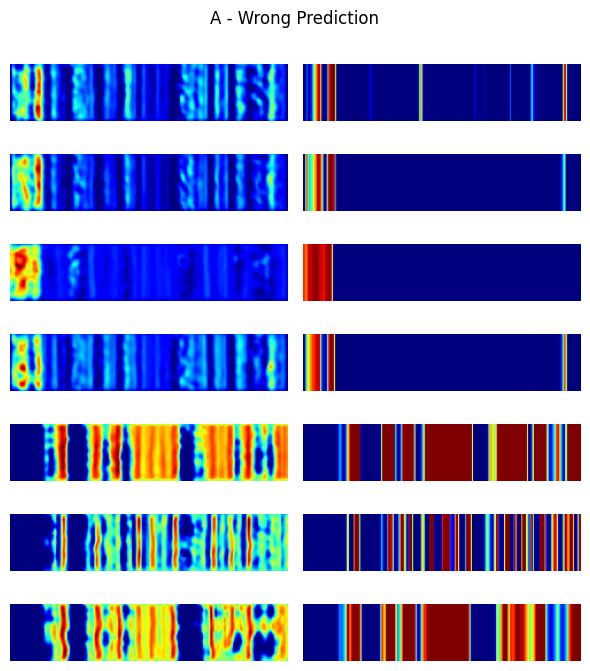

In [91]:
def plot_some_gradcams(df_subset, basedir, title):
  rows = len(df_subset)
  cols = 2
  fig, axs = plt.subplots(rows, cols, figsize=(6, 1*rows))
  for row_index in range(rows):
    file_path = f"{basedir}/{df_subset.iloc[row_index]['filename'].replace('mat', 'npy')}"
    gradcam = np.load(file_path)
    gradcam_simplified = simplify_gradcam3(gradcam)
    axs[row_index][0].imshow(gradcam, cmap='jet')
    axs[row_index][0].axis('off')
    axs[row_index][1].imshow(gradcam_simplified, cmap='jet')
    axs[row_index][1].axis('off')    
  plt.suptitle(f'{title}')
  plt.tight_layout()

basedir = test_csv.replace('test_set.csv', '')
df_subset = df.loc[(df['right']== False)&(df['label']=='A')].sort_values(by=['filename'])
plot_some_gradcams(df_subset, basedir, 'A - Wrong Prediction')

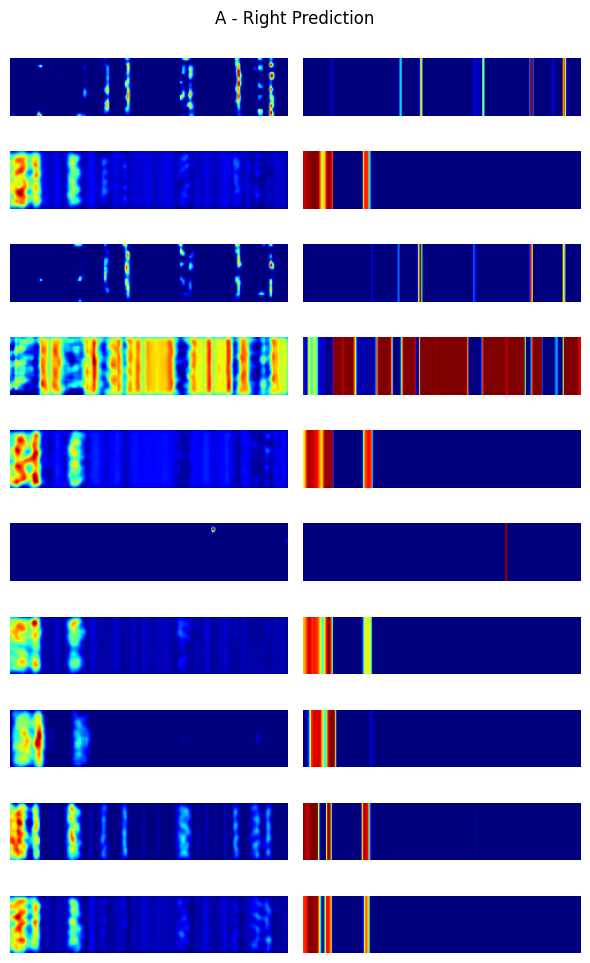

In [96]:
df_subset = df.loc[(df['right']== True)&(df['label']=='A')].sort_values(by=['filename']).sample(n=10)
plot_some_gradcams(df_subset, basedir, 'A - Right Prediction')

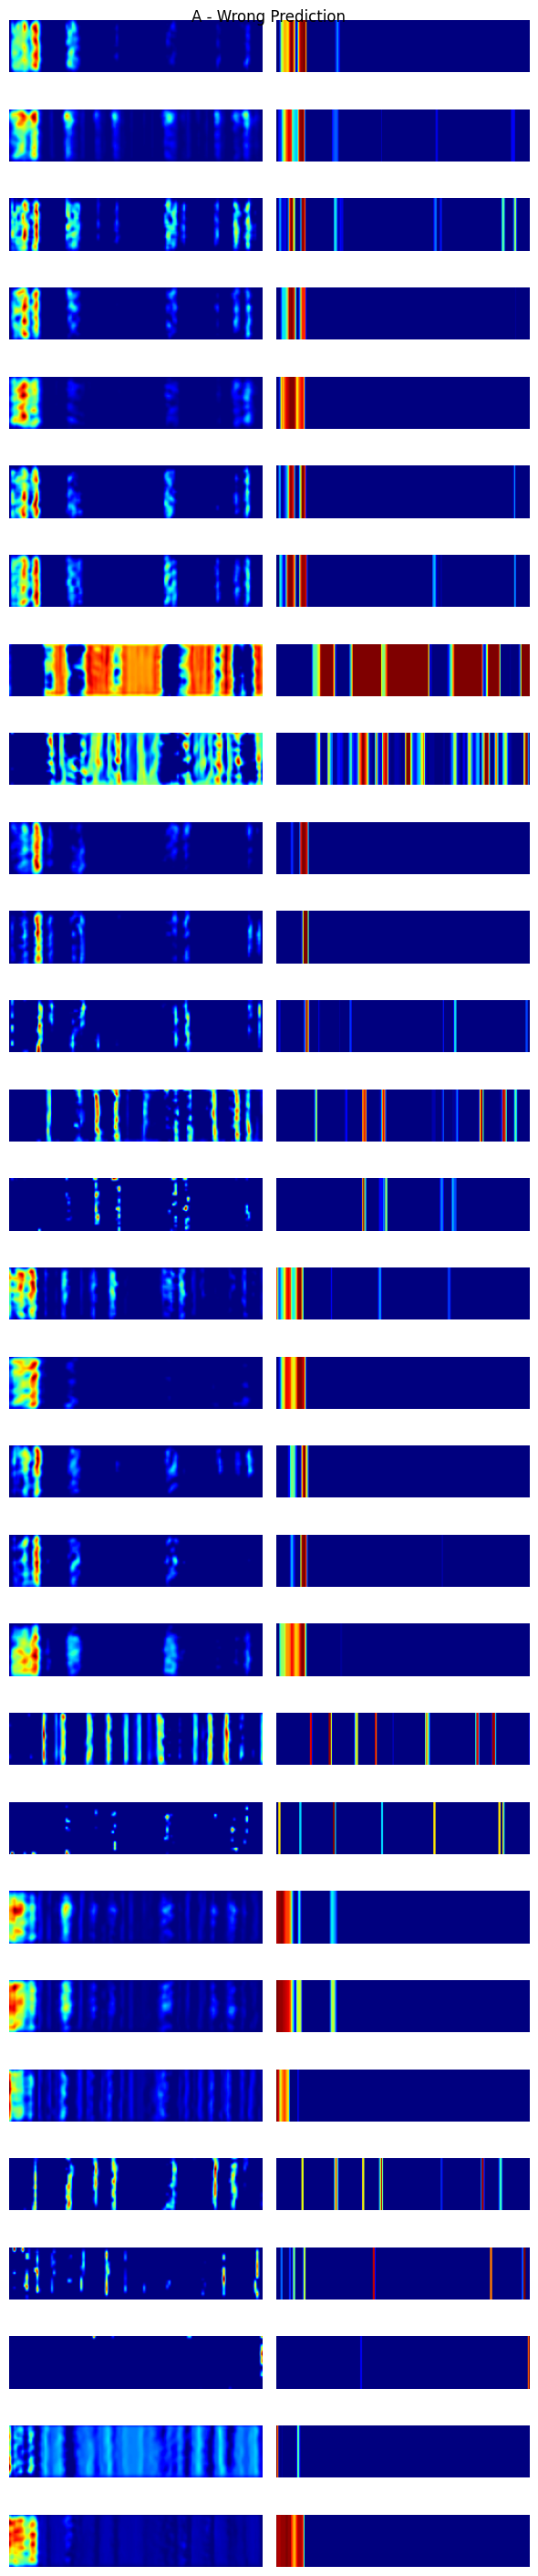

In [92]:
df_subset = df.loc[(df['right']== False)&(df['label']=='B')].sort_values(by=['filename'])
plot_some_gradcams(df_subset, basedir, 'A - Wrong Prediction')

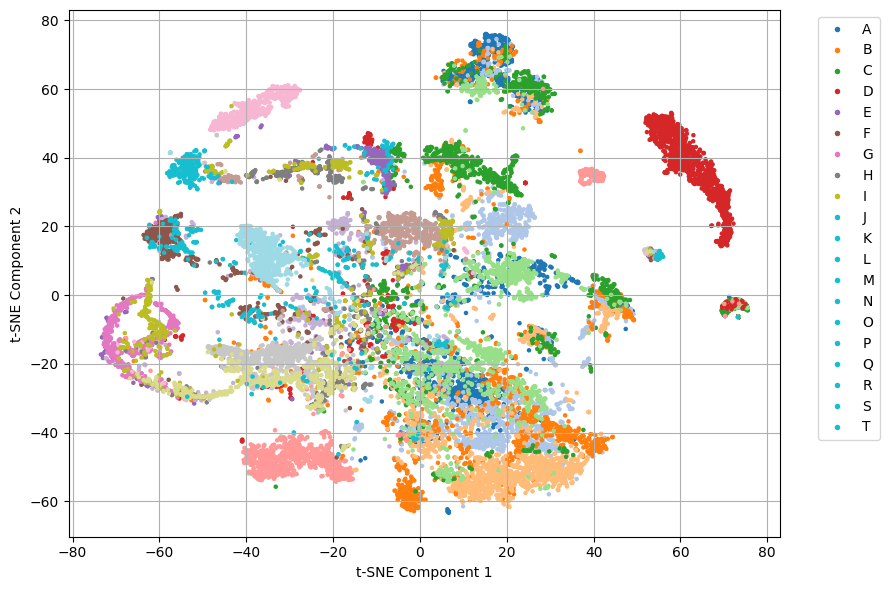

In [107]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

def plot_gradcam_tsne(df_subset, basedir, seed=42, perplexity=30):

  X = np.zeros((len(df_subset), 242))

  for row_index in range(len(df_subset)):
    file_path = f"{basedir}/{df_subset.iloc[row_index]['filename'].replace('mat', 'npy')}"
    gradcam = np.load(file_path)
    gradcam_simplified = np.sum(np.where(gradcam >= 0.40, 1, 0), axis=0)
    X[row_index] = gradcam_simplified

  X = X.astype(np.float32)

  labels = df_subset['label'].tolist()

  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_

  colormap = 'tab20' if len(labels) > 10 else 'tab10'

  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_embedded = tsne.fit_transform(X)
  plt.figure(figsize=(8,6))
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=numeric_labels, cmap=colormap, s=5)
  # plt.title(f't-SNE label: {label} test: {test}, environment: {environment}, slot: {slot}, set: {set_set}')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.grid(True)
  plt.tight_layout()

  plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=class_name, markersize=5, markerfacecolor=plt.cm.tab10(i)) for i, class_name in enumerate(class_names)], loc='upper right', bbox_to_anchor=(1.15, 1))

  # plt.savefig(output_file, dpi=300, bbox_inches='tight')
  plt.show()

basedir = test_csv.replace('test_set.csv', '')
df_subset = df.loc[(df['right']== True)].sort_values(by=['filename'])
plot_gradcam_tsne(df_subset, basedir, seed=42, perplexity=100)